# Objective
In this exercise, we will model the term structure and use it to calculate the no arbitrage price of a convertable bond. To do this, we will estimate the time $t$ short rate $r_t$ and suppose the Expectation Hypothesis holds. That is, we will use an estimate $\hat{r}_t$ for $r_t$ and then approximate the time $t$ yield of a bond maturing at time $T$, i.e. $y_t(T)$, via 
$$
\hat{y}_t(T) = \frac{1}{T - t}\int_t^T \hat{r}_s\ ds.
$$
The yield $\hat{y}$ is a continously componded rate in this calculation. See [França and Gaspar](https://cemapre.iseg.ulisboa.pt/archive/seminars/328.pdf) for a discussion of the validity of the Expectation Hypothesis.

The short rate will be modeled by one-factor and two-factor Vasicek processes. In particular, we will suppose
$$
\hat{r}_t = \rho_t^{(0)}\quad\text{or}\quad \hat{r}_t = \rho_t^{(0)} + \rho_t^{(1)}
$$
where
$$
d\rho_t^{(i)} = \kappa_i \left(\theta_i - \rho_t^{(i)}\right)\ dt + \sigma_i\ dW^{(i)}.
$$
The stochastic processes $W^{(0)}$ and $W^{(1)}$ denote independent Brownian motions under the risk neutral measure $\mathbb{Q}$.

To obtain the parameters $\kappa_i,\ \theta_i,\ \text{and}\ \sigma_i$, we will use the zero-coupon bond yields published on the [Treasury Department website](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/textview.aspx?data=yield). The table gives yields for a set maturities which we will call $\mathcal{T}$. We annualize the yields and convert them into a continously compounded rates $y_t(T)$ for $T$ in $\mathcal{T}$. Then the parameters are approximated by minimizing
$$
\sum_{T\in\mathcal{T}} w_T\left[y_t(T) - \hat{y}_t(T)\right]^2.
$$
The value $w_T$ is a weight and will be explained further later in this exercise. The initial time $t$ corresponds to May 19, 2021.

After we have modeled the short rate, the remainder of the convertable bond valuation is standard complex derivative valuation. We suppose the time $s$ underlying stock price $S_s$ satisfies the stochastic differential equation
$$
dS_s =\ \hat{r}_t\ S_s\ dt + \sigma_S S_s\ dW^{(S)},
$$
where $W^{(S)}$ denotes a third independent Brownian motion under $\mathbb{Q}$.
Let $K$, $m$, and $B$ denote the convertable bond strike price, maturity, and pay-off if not exercised, respectivly. Then the value of the convertable bond is approximately
$$
\mathbb{E}_t^{\mathbb{Q}}\left[\exp\left(-\int_t^m \hat{r}_s\ ds\right)\cdot\left( S_m\mathbb{1}_{S_m \geq K} + B\mathbb{1}_{S_m < K}\right)\right].
$$

# Packages

In [247]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
import time

# Start the clock!
start_time = time.time()

# Use LaTeX in graphs
plt.rcParams.update({"text.usetex": True})

# Yield curve data
As mentioned previously, we obtained the data from the [Treasury Department website](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/textview.aspx?data=yield). Their website contains a [FAQ page](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/interest-rates-frequently-asked-questions) with further details. The yields are estimated using Treasury bills and bonds and smoothed using a cubic spline. 

The zero-coupon yields are compounded semiannually and written as a percent. However, we need the yields to be continously componded decimal expressions to be consistant with the rates we are modeling. Denote the semiannually compounded interest rate on the Treasury Department website by $i_t(T)$. We need to apply the transformation
$$
i_t(T)\mapsto y_t(T) = 2\log\left(1 + \frac{i_t(T)}{200}\right)
$$
to convert the yields to continously compounded decimal expressions $y_t(T)$ for $T$ in $\mathcal{T}$. The value $T$ is measured in years. The Treasury Department website was accessed on May 19, 2021, so $t$ corresponds to this value. For computational ease, we suppose $t = 0$ corresponds to May 19, 2021. The raw zero-coupon bond yields we used are shown below.
$$
\begin{array}{c | c c c c c c c c c c c c}
  T    &  \frac{1}{12}  & \frac{2}{12}  & \frac{3}{12}  & \frac{6}{12}  & 1  & 2  & 3  & 5  & 7  & 10  & 20  & 30\\\hline
 i_t(T)  &  0.00  & 0.01 & 0.01  & 0.03  & 0.05  & 0.16  & 0.35  & 0.87  & 1.34  & 1.68  & 2.3  & 2.38
\end{array}
$$



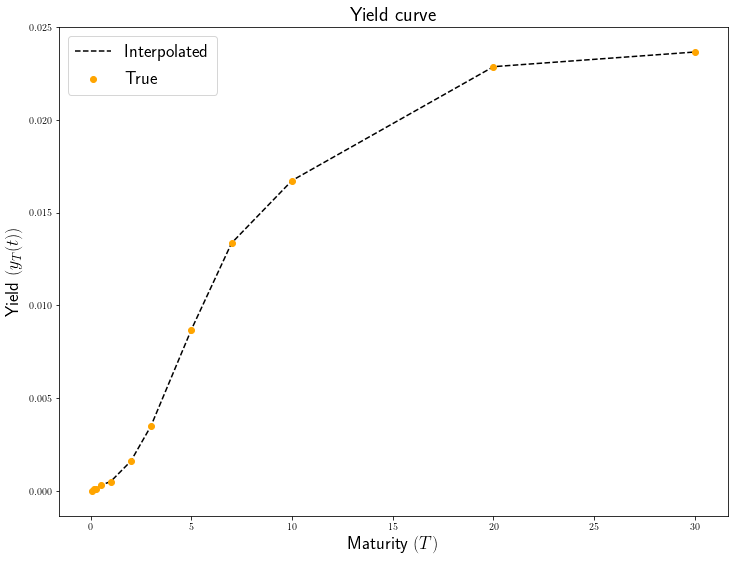

In [248]:
# Initialize rates array
rates = np.zeros((2, 12))

# The 0-th row denotes the maturity times, i.e. the T-values
rates[0, :] = [1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]

# The 1st row denotes the yields; currently these are semi-annually compounded values
rates[1, :] = [0.00, 0.01, 0.01, 0.03, 0.05, 0.16, 0.35, 0.87, 1.34, 1.68, 2.3, 2.38]

# Convert to continously compounded values
rates[1, :] = 2 * np.log(1 + rates[1, :]/200)

# We will graph the yield curve
fig, ax = plt.subplots(1, 1, figsize = (12, 9))

# Record title and label axes
ax.set_title(r'Yield curve', fontsize = 20)
ax.set_xlabel(r'Maturity $(T)$', fontsize = 18) 
ax.set_ylabel(r'Yield $\Big(y_T(t)\Big)$', fontsize = 18) 

# Plots
ax.plot(rates[0, :], rates[1, :], color = 'black', label = 'Interpolated', linestyle = 'dashed', zorder = 0)
ax.scatter(rates[0, :], rates[1, :], color = 'orange', label = 'True', zorder = 1)

# Add legend to plot; placement is automatic
ax.legend(fontsize = 18)

plt.show()

# Vasicek model
Following the formulas in [França and Gaspar](https://cemapre.iseg.ulisboa.pt/archive/seminars/328.pdf), under the Vasicek model the price of a zero-coupon bond at $t = 0$, which pays 1 at $T$, is
$$
P(T;\ \hat{r}) = A(T) \exp\Big[-\hat{r}_0\cdot B(T)\Big]
$$
where
$$
A(T) = \exp\left[\left(\theta - \frac{\sigma^2}{2\kappa^2}\right)\Big(B(T) - T\Big) - \frac{\sigma^2}{4\kappa}\Big(B(T)\Big)^2\right]
$$
and
$$
B(T) = \frac{1}{\kappa}\left[1 - \exp(-\kappa T)\right].
$$
Therefore, the approximation of the true yield with a one-factor Vasicek model is
$$
\hat{y}_0\left(T;\ \rho^{(0)}\right) = -\frac{1}{T}\log P(T;\ \hat{r}_0 = \rho^{(0)}) = -\frac{1}{T}\left[\left(\theta - \frac{\sigma^2}{2\kappa^2}\right)\Big(B(T) - T\Big) - \frac{\sigma^2}{4\kappa}\Big(B(T)\Big)^2 -\rho_0\cdot B(T)\right].
$$

The yield for a two-factor Vasicek is simply the sum of two yields as calculated above. To see why, first recall that the Brownian motions within the diffusion terms of the stochastic differential equations for $\rho^{(0)}$ and $\rho^{(1)}$ are independent. This implies
\begin{align*}
P\left(T; \hat{r} = \rho^{(0)} + \rho^{(1)}\right) 
&= \mathbb{E}_t^{\mathbb{Q}}\left[\exp\left(-\int_0^T \hat{r}_s\ ds\right)\right]\\
&= \mathbb{E}_t^{\mathbb{Q}}\left[\exp\left(-\int_0^T \rho^{(0)}_s + \rho^{(1)}_s\ ds\right)\right]\\
&= \mathbb{E}_t^{\mathbb{Q}}\left[\exp\left(-\int_0^T \rho^{(0)}_s\ ds\right)\exp\left(-\int_0^T\rho^{(1)}_s\ ds\right)\right]\\
&= \mathbb{E}_t^{\mathbb{Q}}\left[\exp\left(-\int_0^T \rho^{(0)}_s\ ds\right)\right]\mathbb{E}_t^{\mathbb{Q}}\left[\exp\left(-\int_0^T \rho^{(1)}_s\ ds\right)\right]\\
&= P\left(T; \rho^{(0)}\right)P\left(T; \rho^{(1)}\right).
\end{align*}
Therefore, the approximation of the true yield using a two-factor Vasicek model is

\begin{align*}
\hat{y}_0(T;\ \rho^{(0)} + \rho^{(1)}) &= -\frac{1}{T}\log P\left(T;\ \hat{r} = \rho^{(0)} + \rho^{(1)}\right)\\
&= -\frac{1}{T}\log\Big[ P\left(T;\ \rho^{(0)}\right) P\left(T;\ \rho^{(1)}\right)\Big]\\
&= -\frac{1}{T}\log P\left(T;\ \rho^{(0)}\right) - \frac{1}{T}\log P\left(T;\ \rho^{(1)}\right)\\
&= \hat{y}_0\left(T;\ \rho^{(0)}\right) + \hat{y}_0\left(T;\ \rho^{(1)}\right).
\end{align*}


In [249]:
# Price at t = 0 of a bond with maturity at time T = 0
def vasicek1_yield(T, pars):
    
    # Recrod parameters; makes code more readable
    ρ_0 = pars[0]
    κ = pars[1]
    θ = pars[2]
    σ = pars[3]
    
    # Define function for B
    B = lambda T: (1/κ) * (1 - np.exp(-κ * T))
    
    # Calculate 0th term within exponent of A function
    term_0 = (θ - σ**2/(2 * κ**2)) * (B(T) - T)
    
    # Calculate 1st term within exponent of A function
    term_1 = (-σ**2/(4 * κ)) * (B(T))**2
    
    return (-1/T) * (term_0 + term_1 - ρ_0 * B(T))

# 2-fractor Vasicek is simply sum of individual factors
vasicek2_yield = lambda T, pars: vasicek1_yield(T, pars[0:4]) + vasicek1_yield(T, pars[4:8])

# Fitting the parameters
A one-factor Vasicek model requires us to estimate the four parameters
$$
\rho_0^{(i)},\ \kappa_i,\ \theta_i,\ \text{and}\ \sigma_i.
$$
corresponding to $i = 0$. A two-factor Vasicek model has eight parameters, corresponding to the ones listed above for $i = 0$ and $1$.

We will estimate these parameters by minimizing
$$
\sum_{T \in\mathcal{T}} w_T\left[y_0(T) - \hat{y}_0(T)\right]^2
$$
where $w_T$ is the weight given to time $T$ maturity yields. Because we are mostly concerned with yields prior to the exercise date $m$ of the convertable bond, we let
$$
    w_T = \begin{cases} 2, & T \leq m\\ 1, & T > m.\end{cases}
$$
This weighting system is somewhat arbitrary.

In [250]:
# Record exercise date
exercise_date = 5

# Create function to minimize
def obj(pars, f, exercise_date):
    
    # Calculate square erros
    errors = np.array([(rates[1, i] - f(rates[0, i], pars))**2 for i in range(rates.shape[1])])
    
    # Calculate weights; equal weighting
    wt = np.ones(rates.shape[1])
    
    # Weight yields before the exercise date more so they affect the model more
    wt[rates[0, :] <= exercise_date] = 2
    
    return np.sum(wt * errors)

# Minimize the objective function obj to obtain optimal paramters for the ...

# ... 1-fractor Vasicek model
result1 = opt.minimize(obj, x0 = [0, 1, 0.05, 0.15], args = (vasicek1_yield, exercise_date))
    
# ... 2-factor Vasicek model
result2 = opt.minimize(obj, x0 = [0, 1, -0.02, 0.10, 0, 1, 0.02, 0.10], args = (vasicek2_yield, exercise_date))


We will print the results from the optimization process below. Notice, in particular, whether success is true or false and the parameter values which are labeled x in the printout. For the one- and two-factor Vasicek models the paramater orders are
$$
[\rho_0^{(0)}, \kappa_0, \theta_0, \sigma_0]\quad\text{and}\qquad [\rho_0^{(0)}, \kappa_0, \theta_0, \sigma_0, \rho_0^{(1)}, \kappa_1, \theta_1, \sigma_1],
$$
respectively. 

The value of $\sigma_i$ may be negative. This is not a problem because a negative value of $\sigma_i$ will not affect the yield formulas or the diffusion term of $d\rho^{(i)}$. It will not affect the yield formulas because $\sigma_i$ is always squared, and it will not affect the diffusion term of $d\rho^{(i)}$ because Brownian motion goes either up or down with equal probability.  With these considerations in mind, we tolerate the possibility of a negative $\sigma_i$, because optimization tends to work better on an unbounded domain. 

In [251]:
# Print results for 1-fractor Vasicek
result1

      fun: 2.770773817381004e-05
 hess_inv: array([[ 6.02794613e-02, -1.19601991e+00,  6.54131447e-02,
        -1.83426875e-02],
       [-1.19601991e+00,  9.78987255e+01, -1.00123418e+01,
         9.73560726e+00],
       [ 6.54131447e-02, -1.00123418e+01,  1.41151905e+00,
        -2.06577782e+00],
       [-1.83426875e-02,  9.73560726e+00, -2.06577782e+00,
         6.23267897e+01]])
      jac: array([-6.18627496e-06, -7.82752750e-07, -6.36041750e-06, -4.59423973e-07])
  message: 'Optimization terminated successfully.'
     nfev: 342
      nit: 46
     njev: 57
   status: 0
  success: True
        x: array([-1.11913836e-03,  1.44023096e-01,  3.29251985e-02, -3.05038099e-05])

In [252]:
# Print results for 2-fractor Vasicek
result2

      fun: 8.7897207812683e-07
 hess_inv: array([[ 3.53220214e+00, -8.36811422e+01,  2.27044638e+00,
         6.73684987e+01, -3.05101120e+00, -8.92005068e+01,
         7.85020057e+00, -4.13425159e+00],
       [-8.36811422e+01,  3.73103349e+03, -1.25518926e+02,
        -3.15534224e+03,  6.98968977e+01,  3.90912111e+03,
        -2.78939849e+02,  2.21262947e+02],
       [ 2.27044638e+00, -1.25518926e+02,  8.21832606e+00,
         6.86951480e+01, -2.39509308e+00, -1.31294488e+02,
         1.18796837e+01, -3.67038973e+00],
       [ 6.73684987e+01, -3.15534224e+03,  6.86951480e+01,
         3.15311490e+03, -5.00142211e+01, -3.29762624e+03,
         1.85931054e+02, -2.41302679e+02],
       [-3.05101120e+00,  6.98968977e+01, -2.39509308e+00,
        -5.00142211e+01,  2.77215598e+00,  7.46111165e+01,
        -7.21555185e+00,  2.76544653e+00],
       [-8.92005068e+01,  3.90912111e+03, -1.31294488e+02,
        -3.29762624e+03,  7.46111165e+01,  4.10009878e+03,
        -2.94941697e+02,  2.3047418

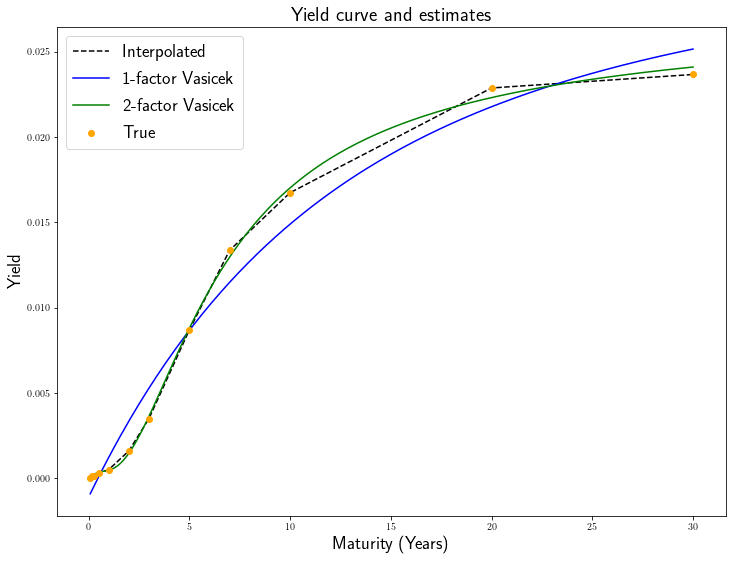

In [253]:
# Record parameter values
pars1, pars2 = result1.x, result2.x 

# Record maturities for the horizontal axis of the theoretical yields
mat = np.linspace(1/12, 30, 200)

# Calculate values of the theoretical yields
est_rates1 = np.array([vasicek1_yield(m, pars1) for m in mat])
est_rates2 = np.array([vasicek2_yield(m, pars2) for m in mat])

fig, ax = plt.subplots(1, 1, figsize = (12, 9))

ax.set_title('Yield curve and estimates', fontsize = 20)
ax.plot(rates[0, :], rates[1, :], color = 'black', label = 'Interpolated', linestyle = 'dashed', zorder = 0)
ax.plot(mat, est_rates1, label = '1-factor Vasicek', color = 'blue', zorder = 1)
ax.plot(mat, est_rates2, label = '2-factor Vasicek', color = 'green', zorder = 2)
ax.scatter(rates[0, :], rates[1, :], color = 'orange', label = 'True', zorder = 3)

ax.set_xlabel(r'Maturity (Years)', fontsize = 18) 
ax.set_ylabel(r'Yield', fontsize = 18) 
ax.legend(fontsize = 18)

plt.show()

# Results
Under the risk netural measure $\mathbb{Q}$, we suppose the dynamics of stock $S_s$ are modeled by
$$
dS_s = \hat{r}_sS_s\ dt + \sigma_S S_s\ dW^{(S)},
$$
where $W^{(S)}$ denotes another independent Brownian motion under the probability measure $\mathbb{Q}$. In order to conduct our valuation we need specific parameter values. We suppose
$$
S_0 = 90\quad\text{and}\quad \sigma_S = 0.20.
$$
We suppose that the bond can only be converted into a stock if the stock's value is above 110. If the stock does not exceed this threshold, we suppose the bond pays 100. Recall that we already supposed that the bond can only be exercised at $T = 5$.

In [254]:
# Convertable bond information
S_0 = 90
σ_S = 0.20
strike = 110
bond = 100

print(f'Recall that the convertable bond is exercised at T = {exercise_date}.')

Recall that the convertable bond is exercised at T = 5.


In the following steps, we run the Monte Carlo simulations. If each simulated path has $N$ steps, then the time elapsed between the start of consecutive steps is $\delta = T/N$. We will suppose that the process is deterministic within each time interval $\left[t + n\delta, t + n\delta + \delta\right)$ for $n = 0, 1,\ldots N - 1$. Since $W_{t + n\delta + \delta} - W_{t + n\delta} \sim{\mathcal{N}(0, \delta)}$, we can approximate the the path of each Brownian motion by sampling $Z\sim{\mathcal{N}(0, 1)}$ and using
$$
\sqrt{\delta}Z\quad\text{for}\quad W_{t + n\delta + \delta} - W_{t + n\delta}.
$$

Under the assumption that $\hat{r}_s$ is constant from time $s$ to $s + \delta$, we can solve the stochastic differential equation which governs the movement of $S_s$. We have
$$
dS_s = \hat{r}_s S_s\ dt + \sigma_S S_s\ dW^{(S)}\quad\text{implies}\quad S_{s + \delta} = S_s\exp\left[\left(\hat{r}_s - \frac{\sigma_S^2}{2}\right)\delta + \sigma_S\sqrt{\delta} Z\right].
$$
The approximation
$$
e^x \approx 1 + x
$$
allows us to say
$$
S_{s + \delta} \approx S_s + \left(\hat{r}_s - \frac{\sigma_S^2}{2}\right)S_s\delta + \sigma_SS_s\sqrt{\delta} Z.
$$

We also need to model the movement of $\rho^{(i)}$. We have that
$$
d\rho^{(i)} = \kappa_i (\theta_i - \rho^{(i)})\ dt + \sigma_i\ dW^{(i)}
\quad\text{implies}\quad
\rho_{s + \delta}^{(i)} = \rho_s^{(i)} e^{-\kappa_i\delta} + \theta_i - \theta_i e^{-\kappa_i\delta} + \sigma_i e^{-\kappa_i(s + \delta)}\int_s^{s + \delta} e^{\kappa_i \tau}\ dW_\tau^{(i)}.
$$
Using the area of one rectangle to approximate a definite integral and, once again, using $e^x\approx 1 + x$, we have
\begin{align*}
\rho_{s + \delta}^{(i)} 
&= \rho_s^{(i)} e^{-\kappa_i\delta} + \theta_i - \theta_i e^{-\kappa_i\delta} + \sigma_i e^{-\kappa_i(s + \delta)}\int_s^{s + \delta} e^{\kappa_i \tau}\ dW_\tau^{(i)}\\
&\approx \rho_s^{(i)} (1 -\kappa_i\delta) + \theta_i - \theta_i (1 -\kappa_i\delta) + \sigma_i e^{-\kappa_i\delta} \sqrt{\delta} Z\\
&\approx \rho_s^{(i)} (1 -\kappa_i\delta) + \theta_i - \theta_i (1 -\kappa_i\delta) + \sigma_i (1 -\kappa_i\delta) \sqrt{\delta} Z\\
&= \rho_s^{(i)} (1 -\kappa_i\delta) + \kappa_i\theta_i\delta + \sigma_i (1 -\kappa_i\delta) \sqrt{\delta} Z.
\end{align*}
All of our approximations improve as $\delta$ approaches zero. 

We considered antithetic cases of $Z$ when simulating the path of $S_s$ to reduce variance. However, we skip antithetic cases for the Vasicek rates to enhance the readability and simplicity of our code.

In [255]:
# Simulation information
path_steps = 500
simulations = 10**4

def run_sim1(path_steps, pars):
    
    # Calculate increment for each path
    δ = exercise_date/path_steps
    
    # Create array to record interest rate from time s to s + δ
    ρ_0 = np.zeros(shape = path_steps + 1)
    
    # Create array to record stock value at time s
    S = np.zeros(shape = (path_steps + 1, 2))
    
    # Initialize array
    ρ_0[0] = pars[0]
    S[0, :] = S_0
    
    # Create array to make it easy to consider anithetic case
    antithetic = np.array([1, -1])
    
    # Create function to make it easy to calculate new rho from old rho
    def get_ρ(ρ, Z, pars):
        
        # Terms in expression for new row
        term_0 = (1 - pars[1] * δ) * ρ
        term_1 = pars[1] * pars[2] * δ
        term_2 = pars[3] * (1 - pars[1] * δ) * np.sqrt(δ) * Z
        
        return term_0 + term_1 + term_2
    
    # Create function to make it easy to calcylate new S from old
    get_S = lambda S, r, Z: S + S * (r - 0.5 * σ_S**2) * δ + σ_S * S * np.sqrt(δ) * Z * antithetic
  
    for i in range(path_steps):
        
        # Simulate two standard normal random variables
        Z = stats.norm.rvs(size = 2)
   
        # Use one of the standard normals to calculate rho
        ρ_0[i + 1] = get_ρ(ρ_0[i], Z[0], pars)
 
        # Use the other to calculate Z; antithetic path is also considered
        S[i + 1, :] = get_S(S[i, :], ρ_0[i], Z[1])
    
    # record final pay-off in two cases
    result = S[path_steps, :] * (S[path_steps, :] > strike) + bond * (S[path_steps, :] <= strike) 
    
    # Taka the mean and discount back to time t; return the result
    return np.mean(result)/np.exp(δ * np.sum(ρ_0[0:path_steps]))

# Run the simulations
sims1 = [run_sim1(path_steps, pars1) for n in range(simulations)]

# Compute the mean of the simulations; this is the price of the bond
price_vasicek1 = np.mean(sims1)

print(f'Using the 1-factor Vasicek interest rate model, the price is {round(price_vasicek1, 2)}.')

Using the 1-factor Vasicek interest rate model, the price is 105.11.


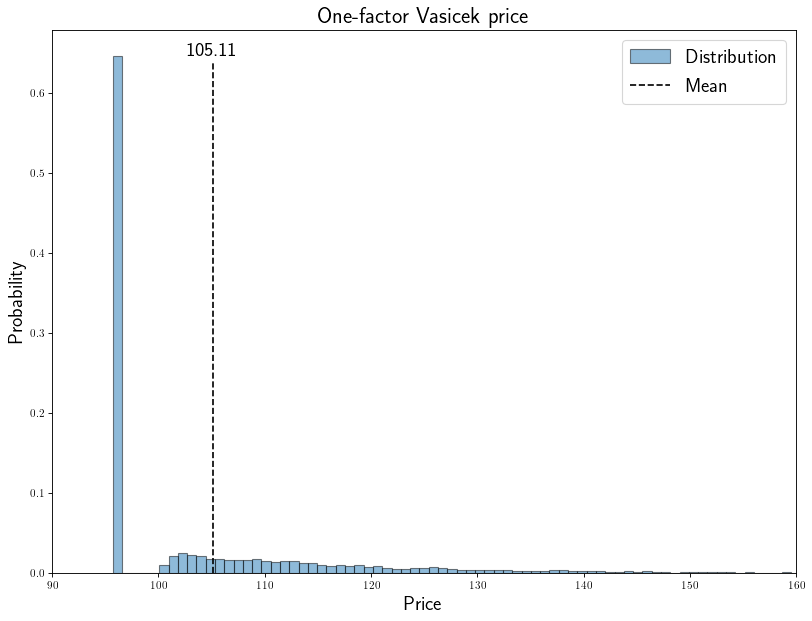

In [260]:
# Record the number of bins in the histograms
num_bins = 150

plt.figure(figsize = (12, 9), dpi = 80)

plt.title('One-factor Vasicek price', fontsize = 20)

n, bins, patches = plt.hist(sims1, num_bins, density = 1, alpha = 0.5, label = 'Distribution', edgecolor = 'black')

plt.vlines(price_vasicek1, 0, 0.99 * np.max(n) , colors = 'k', linestyles = 'dashed', label = 'Mean')
plt.text(price_vasicek1, np.max(n), round(price_vasicek1, 2), ha = 'center', fontsize = 18)

plt.xlim([90, 160])

plt.xlabel(r'Price', fontsize = 18)
plt.ylabel('Probability', fontsize = 18)
plt.legend(fontsize = 18)

plt.show()

In [257]:
def run_sim2(path_steps, pars):
    
    # Calculate step increment
    δ = exercise_date/path_steps
    
    # Create arrays for each factor's path
    ρ_0 = np.zeros(shape = path_steps + 1)
    ρ_1 = np.zeros(shape = path_steps + 1)
    
    # Create array for Stock path
    S = np.zeros(shape = (path_steps + 1, 2))
    
    # Intialize paths
    ρ_0[0] = pars[0]
    ρ_1[0,] = pars[4]
    S[0, :] = S_0
    
    # Create array to make it easy to consider anithetic case
    antithetic = np.array([1, -1])
    
    # Create function to make it easy to calculate new rho from old rho
    def get_ρ(ρ, Z, pars):
        
        # Calculate terms in expression for rho
        term_0 = (1 - pars[1] * δ) * ρ
        term_1 = pars[1] * pars[2] * δ
        term_2 = pars[3] * (1 - pars[1] * δ) * np.sqrt(δ) * Z
        
        return term_0 + term_1 + term_2
    
    # Create a function to make it easy to calculate new S from old S and rhos
    get_S = lambda S, r, Z: S + S * (r - 0.5 * σ_S**2) * δ + σ_S * S * np.sqrt(δ) * Z * antithetic

    for i in range(path_steps):
        
        # Generate three standard normals
        Z = stats.norm.rvs(size = 3)
   
        # Calculate Vasicek rates
        ρ_0[i + 1] = get_ρ(ρ_0[i], Z[0], pars[0:4])
        ρ_1[i + 1] = get_ρ(ρ_1[i], Z[1], pars[4:8])  
        
        # Valuate current value of S
        S[i + 1, :] = get_S(S[i, :], ρ_0[i] + ρ_1[i], Z[2])
    
    # Compute pay-off
    result = S[path_steps, :] * (S[path_steps, :] > strike) + bond * (S[path_steps, :] <= strike) 
    
    # Take the mean of S under the two paths and discount back to time t
    return np.mean(result)/np.exp(δ * np.sum((ρ_0 + ρ_1)[0:path_steps]))

# Run the simulations
sims2 = [run_sim2(path_steps, pars2) for n in range(simulations)]

# Compute the mean of the simulations; this is the price of the bond
price_vasicek2 = np.mean(sims2)

print(f'Using the 2-factor Vasicek interest rate model, the price is {round(price_vasicek2, 2)}.')

Using the 2-factor Vasicek interest rate model, the price is 116.27.


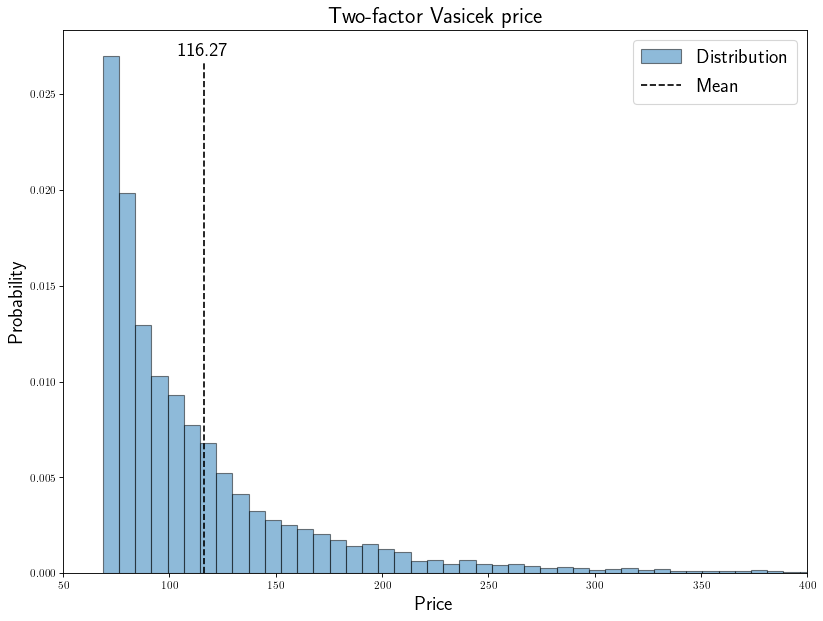

In [258]:
plt.figure(figsize = (12, 9), dpi = 80)

plt.title('Two-factor Vasicek price', fontsize = 20)

n, bins, patches = plt.hist(sims2, num_bins, density = 1, alpha = 0.5, label = 'Distribution', edgecolor = 'black')

plt.vlines(price_vasicek2, 0, 0.99 * np.max(n), colors = 'k', linestyles = 'dashed', label = 'Mean')
plt.text(price_vasicek2, np.max(n), round(price_vasicek2, 2), ha = 'center', fontsize = 18)

plt.xlim([50, 400])

plt.xlabel(r'Price', fontsize = 18)
plt.ylabel('Probability', fontsize = 18)
plt.legend(fontsize = 18)

plt.show()

In [259]:
print('This program took {} minutes to run.'.format(round((time.time() - start_time)/60, 1)))

This program took 13.5 minutes to run.


# Conclusion
The one- and two-fractor Vasicek models produced somewhat consistant estimates for the convertable bond price. In particular, both estimates produced results within about 6 of the average of about 111. The next step would be to verify that these prices are consistant with the true market value of such a bond. 